In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Data preprocessed from kaggle
train = pd.read_pickle("../data/raw/train_agg.pkl", compression="gzip")
test = pd.read_pickle("../data/raw/test_agg.pkl", compression="gzip")

In [122]:
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']


In [2]:
train = pd.read_parquet("../data/raw/train.parquet")
test = pd.read_parquet("../data/raw/test.parquet")

In [3]:
labels = pd.read_csv("../data/raw/train_labels.csv")

In [4]:
train = train.merge(labels, left_on='customer_ID', right_on='customer_ID')

In [5]:
train.head()

customer_ID         S_2       P_2  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09  0.938469   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07  0.936665   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28  0.954180   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13  0.960384   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16  0.947248   

   D_39       B_1       B_2       R_1       S_3  D_41       B_3  ...  D_137  \
0     0  0.008724  1.006838  0.009228  0.124035   0.0  0.004709  ...     -1   
1     0  0.004923  1.000653  0.006151  0.126750   0.0  0.002714  ...     -1   
2     3  0.021655  1.009672  0.006815  0.123977   0.0  0.009423  ...     -1   
3     0  0.013683  1.002700  0.001373  0.117169   0.0  0.005531  ...     -1   
4     0  0.015193  1.000727  0.007605  0.117325   0.0  0.009312  ...     -1   

   D_138  D_139  D_140  D_141  D_142  D_143     D_144  D_145  target  
0     -1      0      0    0.0    NaN      0  0.000610      0       0  
1     -1      0      0    0.0    NaN      0  0.005492      0       0  
2     -1      0      0    0.0    NaN      0  0.006986      0       0  
3     -1      0      0    0.0    NaN      0  0.006527      0       0  
4     -1      0      0    0.0    NaN      0  0.008126      0       0  

[5 rows x 191 columns]

In [6]:
train.shape

(5531451, 191)

# 1. EDA

## Columns in the dataset are divided in the following groups:
* D_*: Delinquency variables
* S_*: Spend variables
* P_*: Payment variables
* B_*: Balance variables
* R _*: Risk variables
- Following features are categorical: B_30, B_38, D_63, D_64, D_66, D_68, D_114, D_116, D_117, D_120, D_126.

* S_2: contains a timestamp

In [7]:
train["S_2"] =  pd.to_datetime(train["S_2"])

In [8]:
train.info(max_cols=200, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Data columns (total 191 columns):
 #    Column       Non-Null Count    Dtype         
---   ------       --------------    -----         
 0    customer_ID  5531451 non-null  object        
 1    S_2          5531451 non-null  datetime64[ns]
 2    P_2          5485466 non-null  float32       
 3    D_39         5531451 non-null  int16         
 4    B_1          5531451 non-null  float32       
 5    B_2          5529435 non-null  float32       
 6    R_1          5531451 non-null  float32       
 7    S_3          4510907 non-null  float32       
 8    D_41         5529435 non-null  float32       
 9    B_3          5529435 non-null  float32       
 10   D_42         791314 non-null   float32       
 11   D_43         3873055 non-null  float32       
 12   D_44         5531451 non-null  int8          
 13   B_4          5531451 non-null  int16         
 14   D_45         5529434 non-null  float32       
 1

In [9]:
train.S_2.min(), train.S_2.max()

(Timestamp('2017-03-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

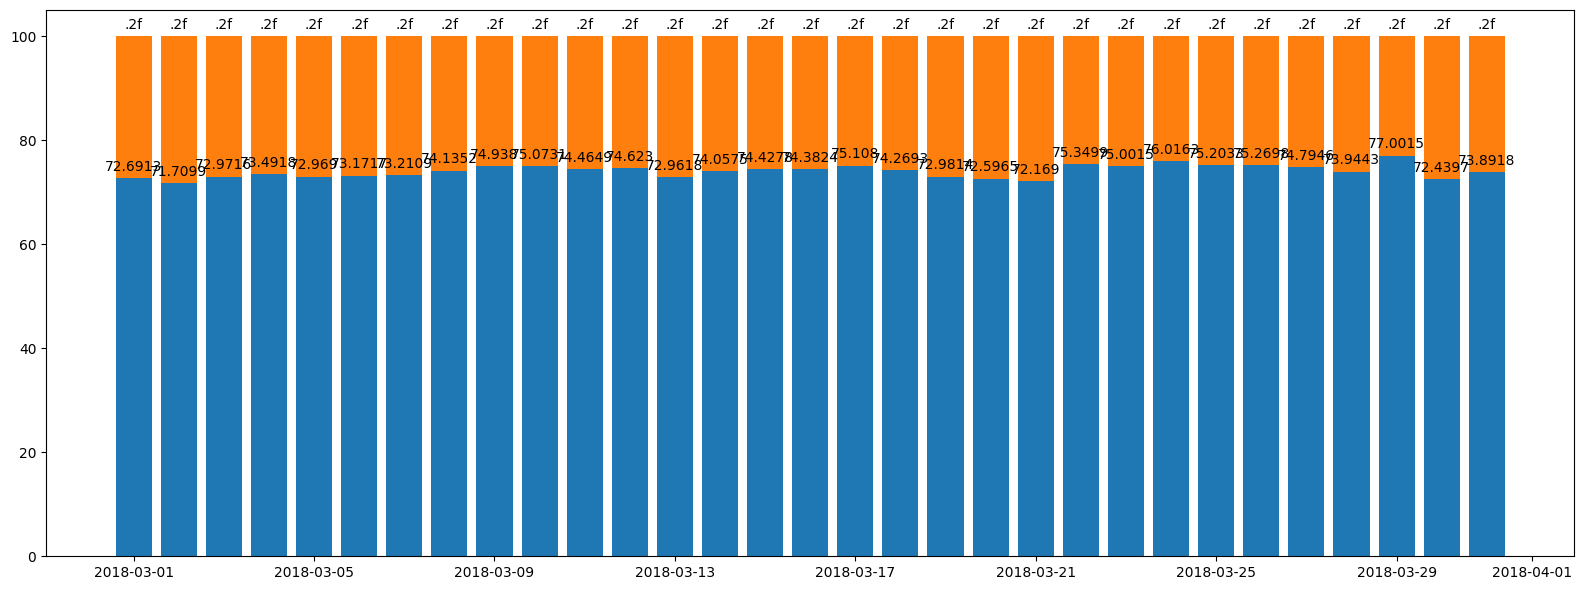

In [132]:
target = pd.DataFrame(data={'Default': train.groupby("S_2")['target'].mean()*100})
target["paid"] = np.abs(train.groupby("S_2")["target"].mean()-1)*100
target2 = target.loc[(target.index>="2018-03-01") & (target.index<="2018-03-31")]
width = 0.8

fig, ax = plt.subplots(1, figsize=(16,6))

p1 = ax.bar(target2.index, target2.paid, label="Paid", width=width)

p2 = ax.bar(target2.index, target2.Default, bottom=target2.paid , label= "Default",  width=width)

fig.tight_layout()

ax.bar_label(p1, padding=3);
ax.bar_label(p2, padding=3);

### Insight - Looks like the proportion is consistent acrros all days.

## Time to look all the variables by type:
* D_* = Delinquency variables

In [121]:
train.head(1)

customer_ID        S_2       P_2  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f... 2017-03-09  0.938469   

   D_39       B_1       B_2       R_1       S_3  D_41       B_3  ...  D_137  \
0     0  0.008724  1.006838  0.009228  0.124035   0.0  0.004709  ...     -1   

   D_138  D_139  D_140  D_141  D_142  D_143    D_144  D_145  target  
0     -1      0      0    0.0    NaN      0  0.00061      0       0  

[1 rows x 191 columns]

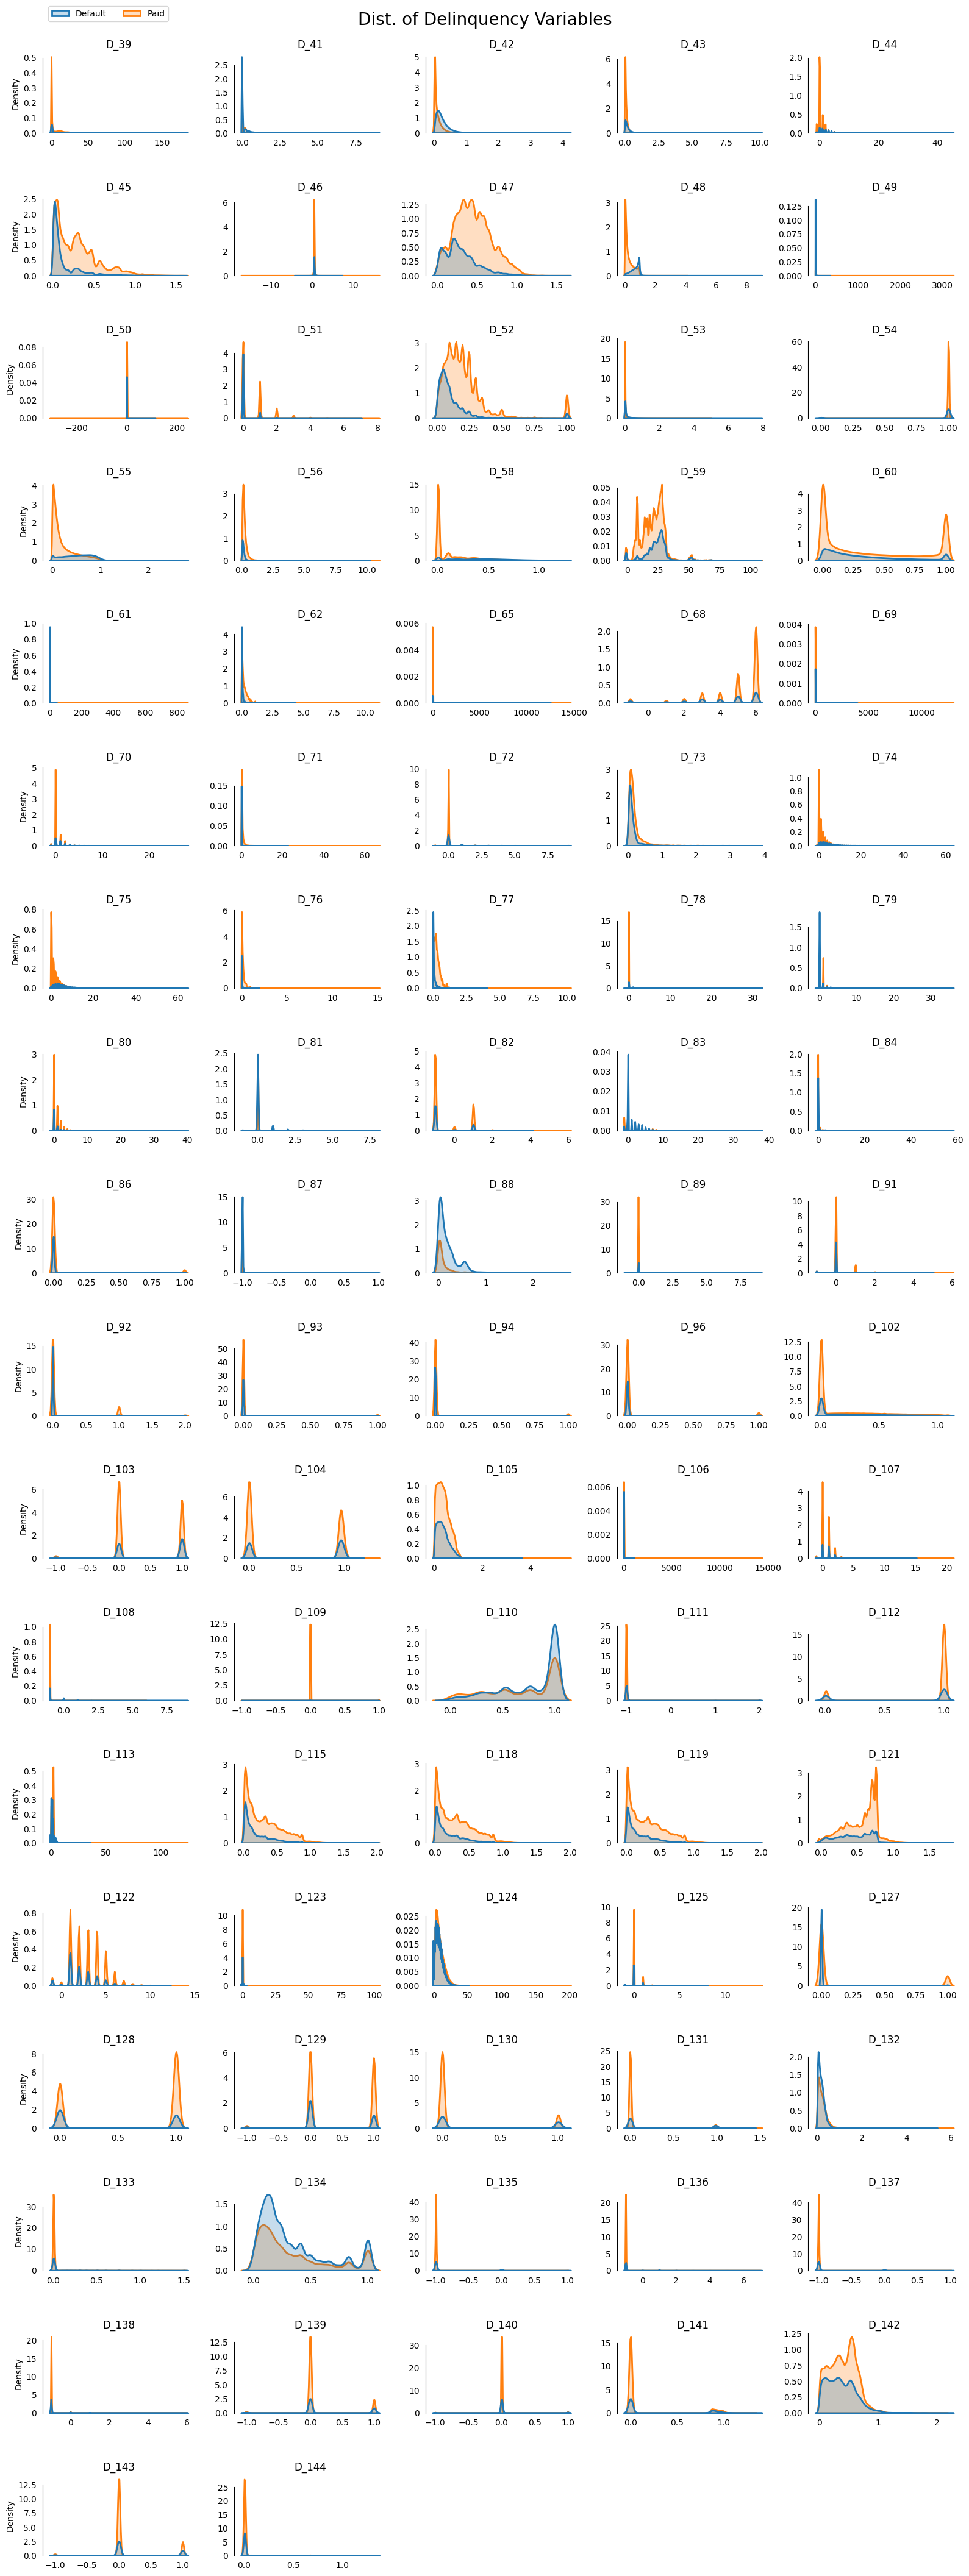

In [131]:
cols = [col for col in train.columns if (col.startswith(("D", "t"))) & (col not in cat_cols[:-1])]

plot_df = train[cols]

fig, ax = plt.subplots(18,5, figsize = (16,54))
fig.suptitle("Dist. of Delinquency Variables", fontsize = 20)

row= 0
col= [0, 1, 2, 3, 4] * 18

for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue= 'target', hue_order=[1,0],
                label = ['Default', 'Paid'], data= plot_df, 
                fill= True, linewidth=2, legend= False, 
                ax=ax[row,col[i]])

    ax[row, col[i]].tick_params(left=False, bottom=False)
    ax[row, col[i]].set(title='\n\n{}'.format(column), xlabel='',
        ylabel= ("Density" if i%5==0 else ""))
for i in range(2,5):
    ax[17,i].set_visible(False)

handles, _ = ax[0,0].get_legend_handles_labels()

fig.legend(labels=["Default","Paid"], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.983))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0,0.2,1,0.99])


Text(0.5, 1.0, 'Correlation between delinquency variables')

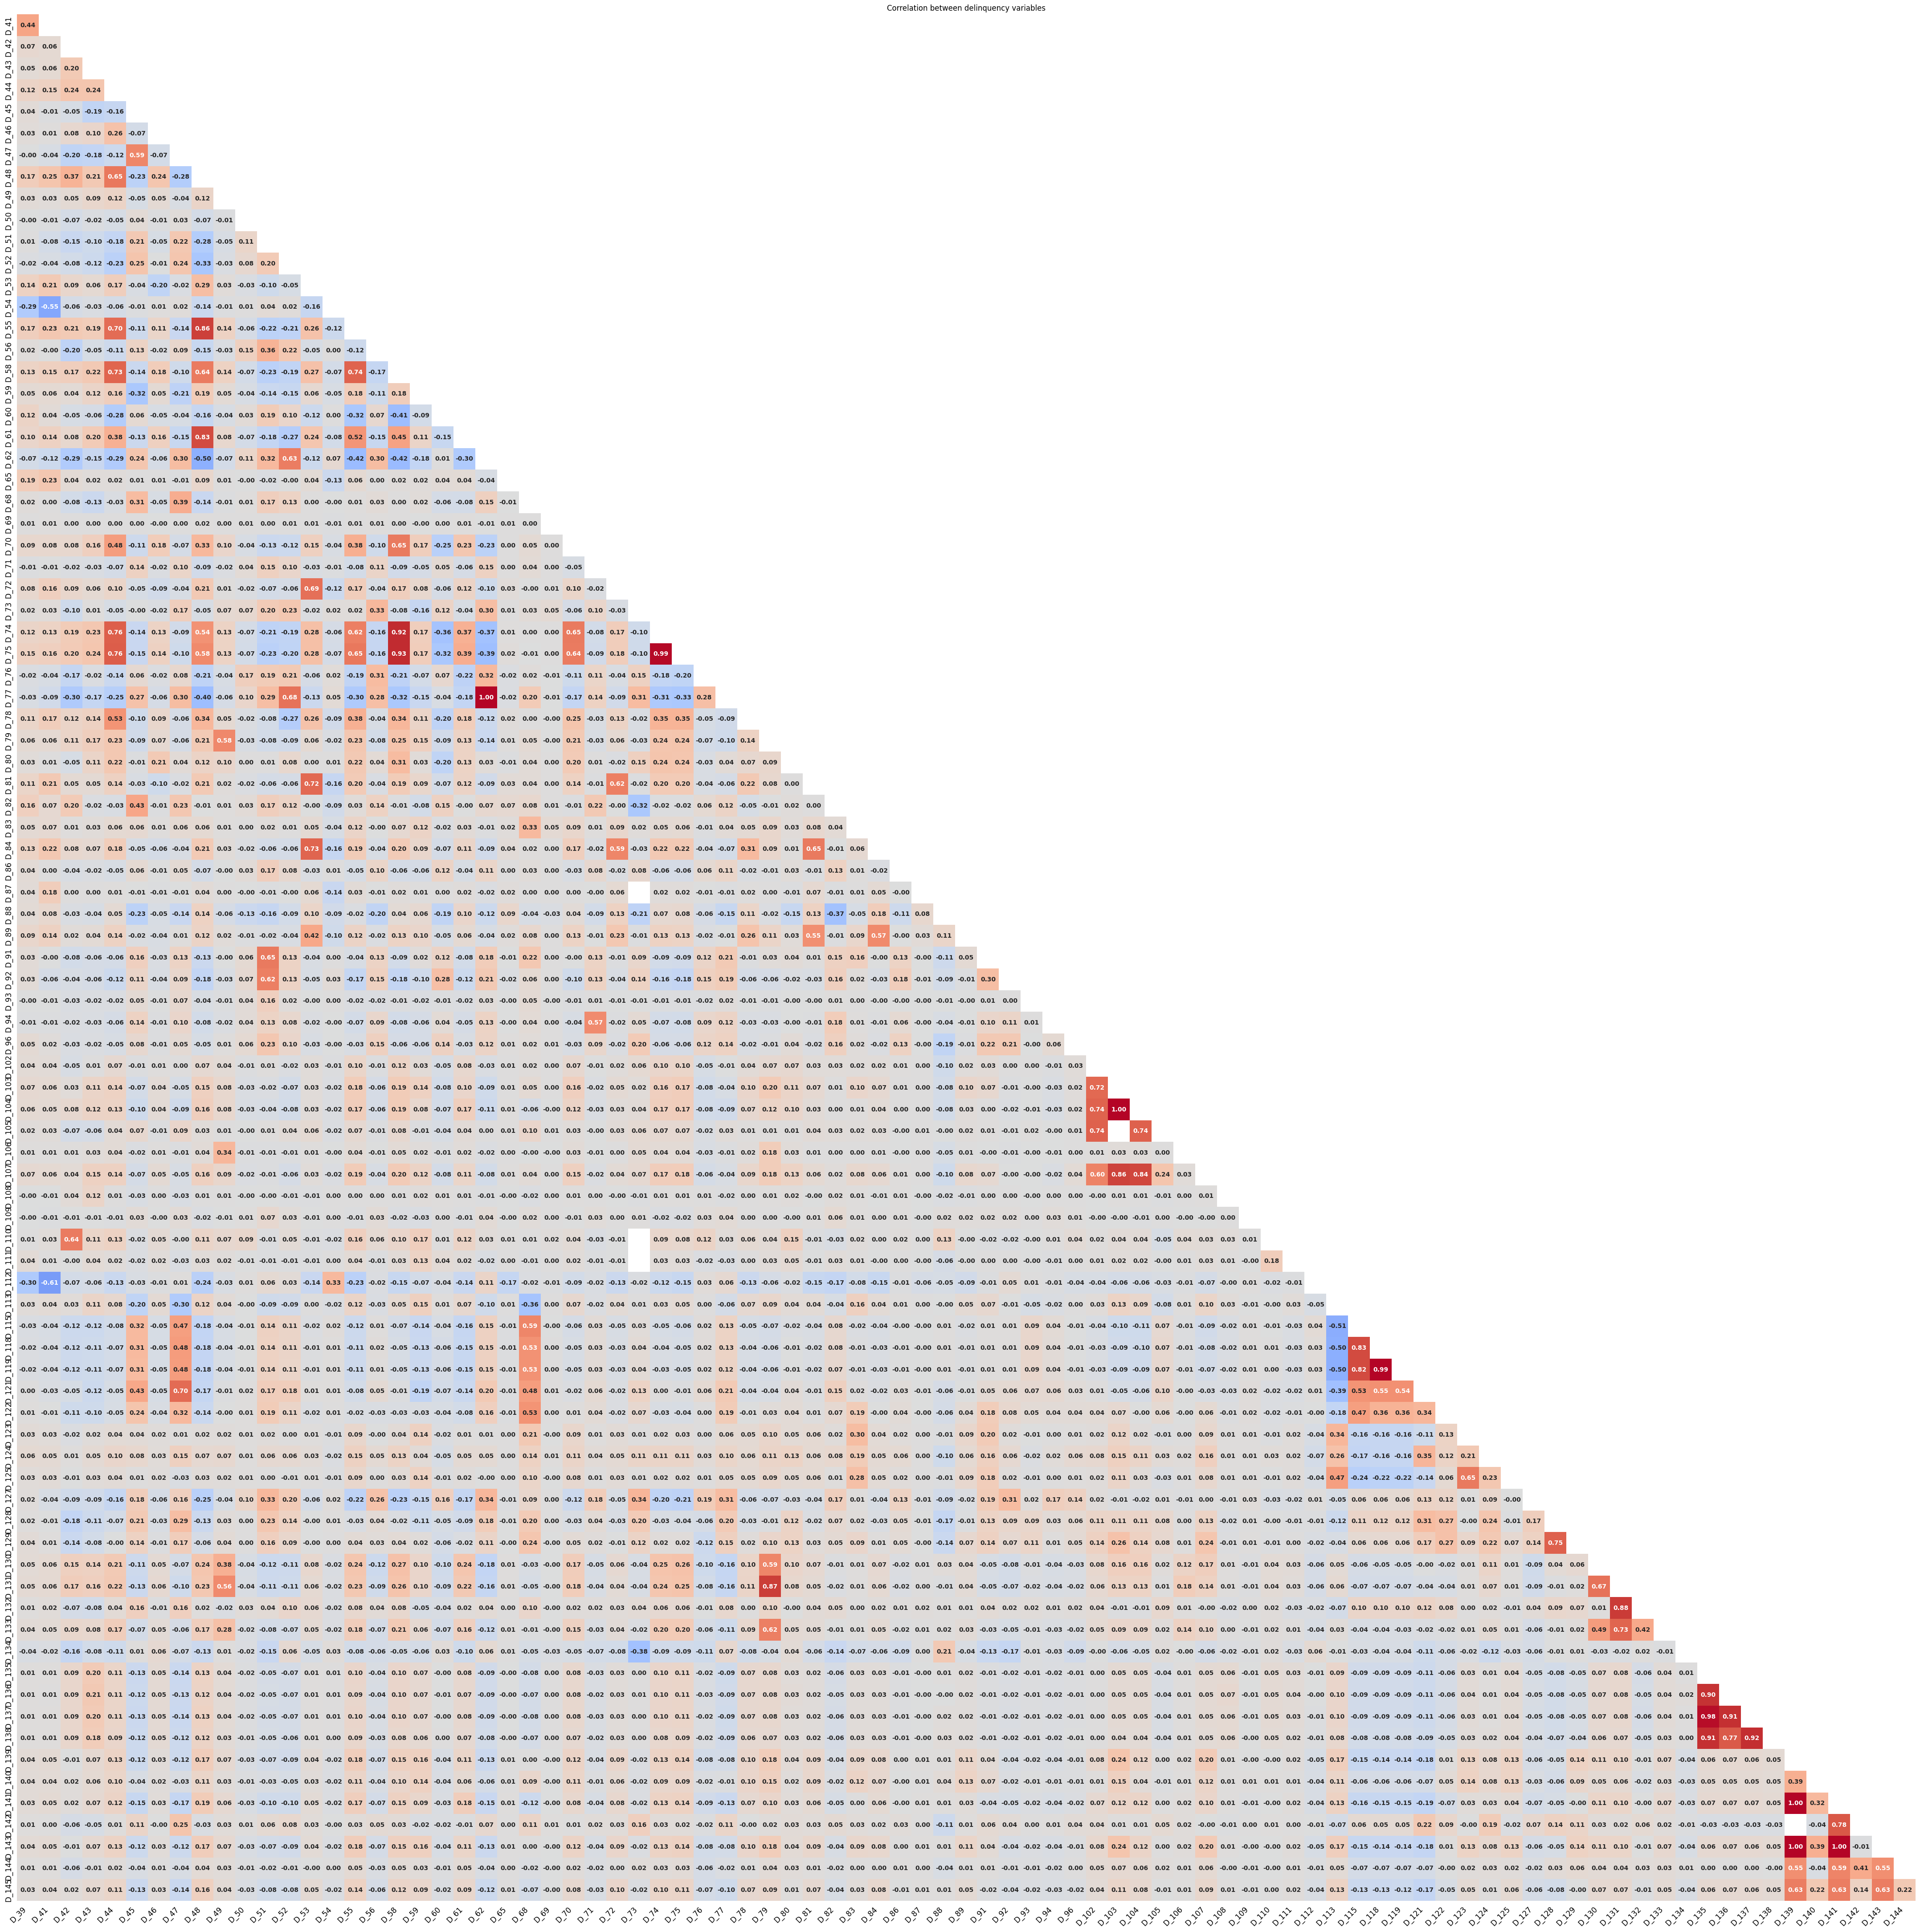

In [136]:
corr= plot_df.iloc[:,:-1].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr = corr.iloc[1:,:-1].copy()

fig, ax = plt.subplots(figsize=(55,55))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f',
            cmap="coolwarm", annot_kws={"fontsize": 10, "fontweight":"bold"},
            cbar=False
            )

ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment= "right", fontsize = 12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 12)
plt.title('Correlation between delinquency variables');

In [145]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [147]:
print(get_top_abs_correlations(corr, n=40))

D_139  D_143    1.000000
D_118  D_119    0.999979
D_135  D_137    0.999918
D_74   D_75     0.998994
D_137  D_138    0.995922
D_135  D_138    0.995571
D_58   D_75     0.995329
D_135  D_136    0.995009
D_136  D_137    0.994928
D_58   D_74     0.993979
D_62   D_77     0.991601
D_115  D_118    0.987778
       D_119    0.987669
D_103  D_107    0.987313
D_139  D_141    0.986113
D_136  D_138    0.983508
D_103  D_104    0.983221
D_44   D_75     0.968912
       D_58     0.967284
       D_74     0.965785
D_48   D_55     0.963167
       D_61     0.958163
D_53   D_84     0.954737
D_55   D_58     0.954474
D_53   D_81     0.953496
D_44   D_55     0.953471
D_81   D_84     0.951480
D_39   D_41     0.947665
D_104  D_107    0.945994
D_102  D_104    0.943677
D_70   D_74     0.941354
D_47   D_121    0.940905
D_55   D_75     0.939214
D_131  D_133    0.938519
D_70   D_75     0.938513
D_53   D_72     0.938185
D_58   D_70     0.936616
D_52   D_77     0.932196
D_55   D_74     0.929175
D_52   D_62     0.927806


### Many variables(Delinquency) with a strong correlation

* S_* = Spend variables


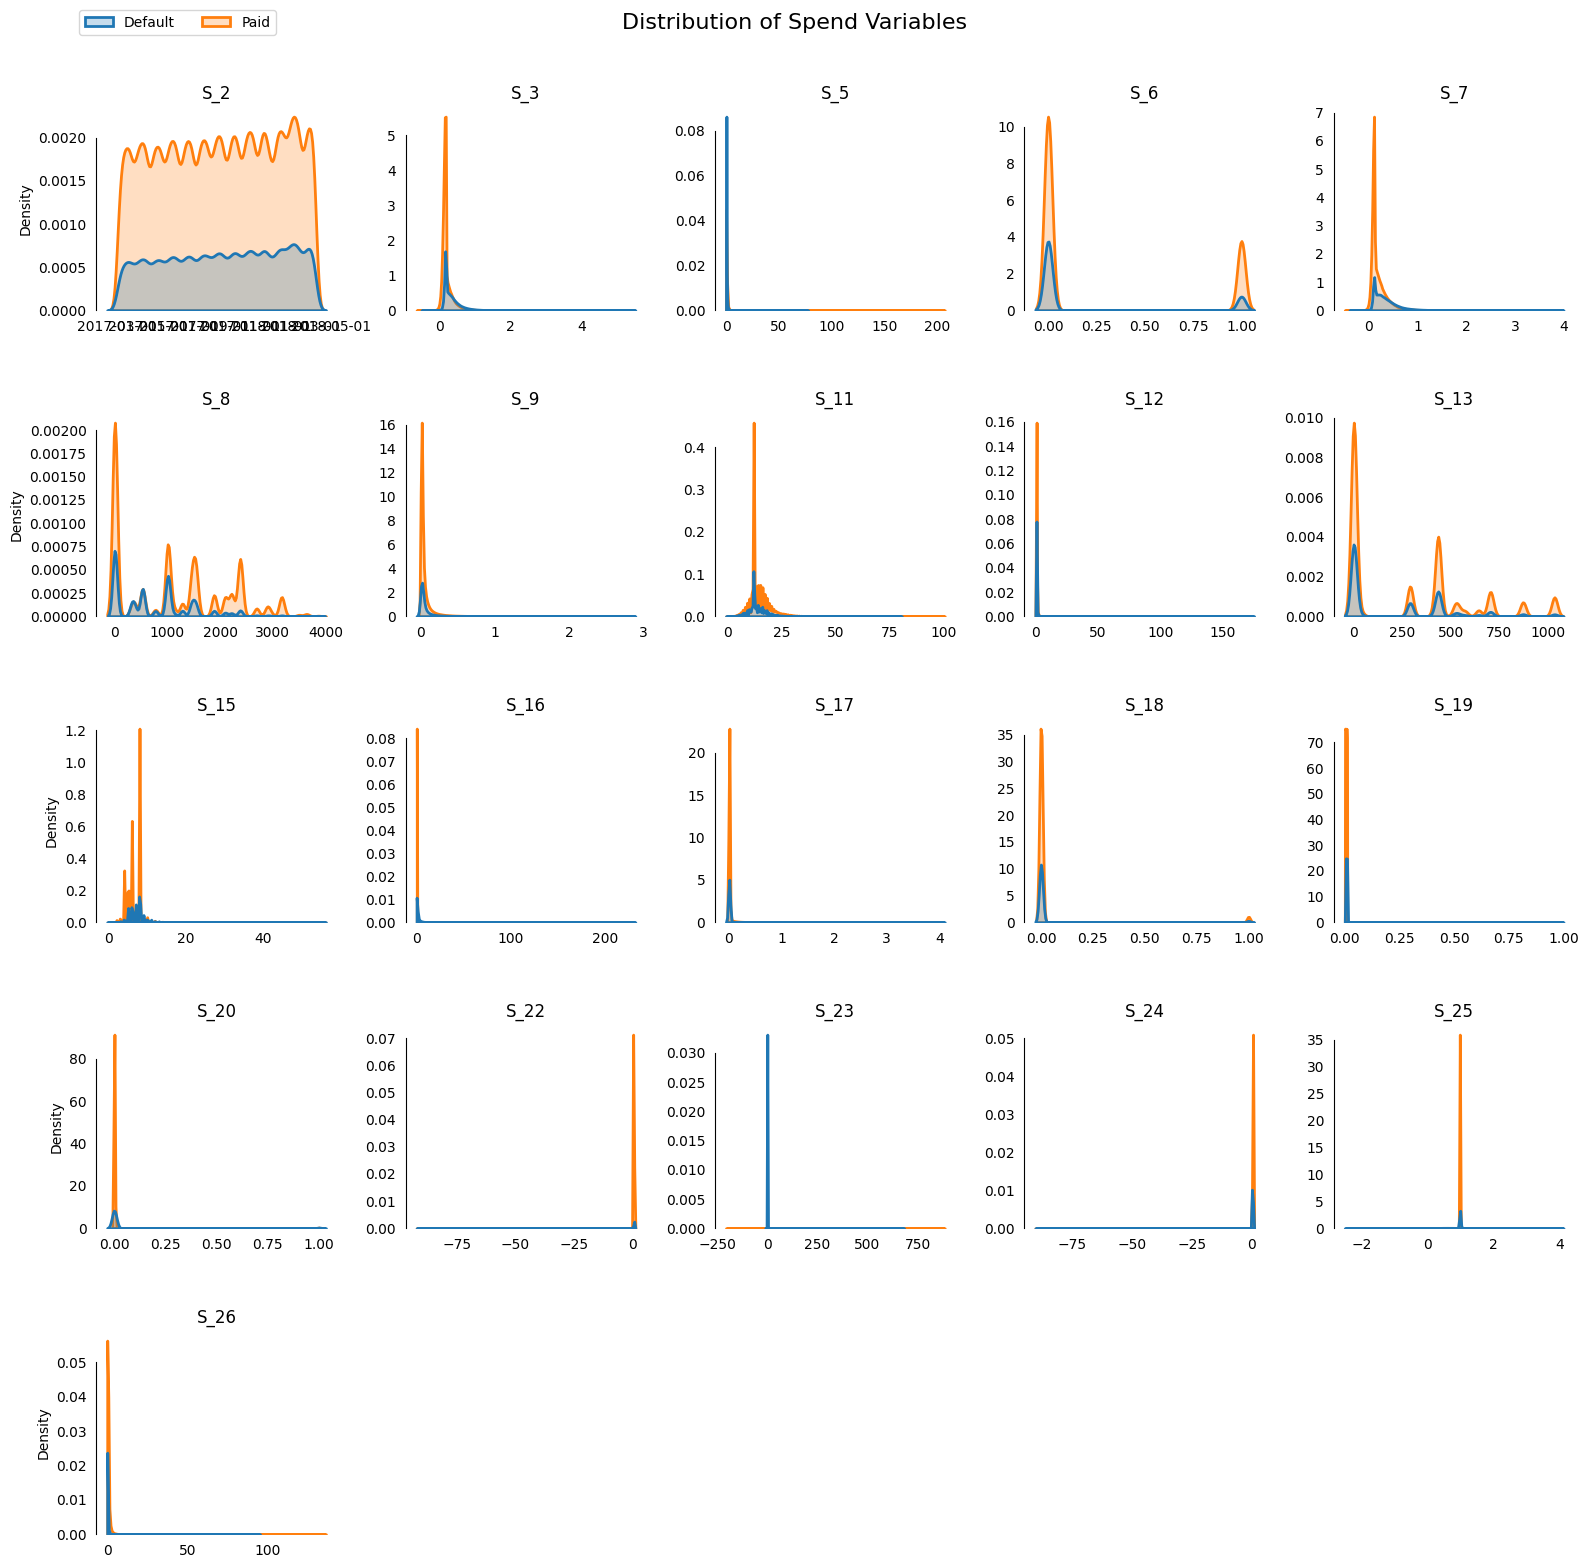

In [149]:
cols=[col for col in train.columns if (col.startswith(('S','t'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(5,5, figsize=(16,20))
fig.suptitle('Distribution of Spend Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*5
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(1,5):
    ax[4,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.985))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

C:\Users\brito\AppData\Local\Temp\ipykernel_4548\1770511596.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


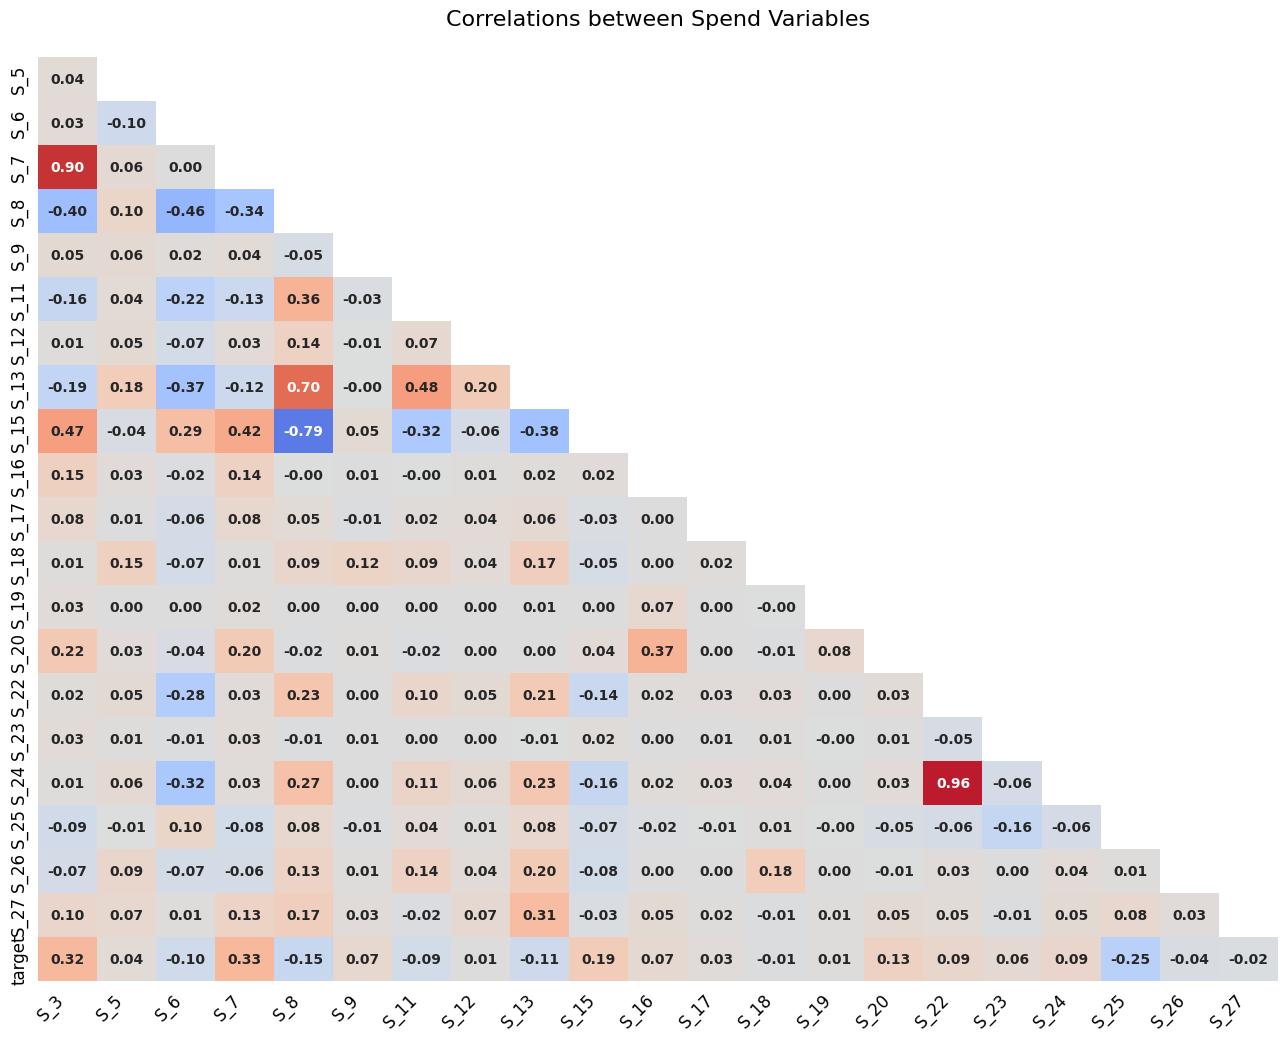

In [150]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(16,12))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Spend Variables\n', fontsize=16)
fig.show()

* P_* = Payment variables

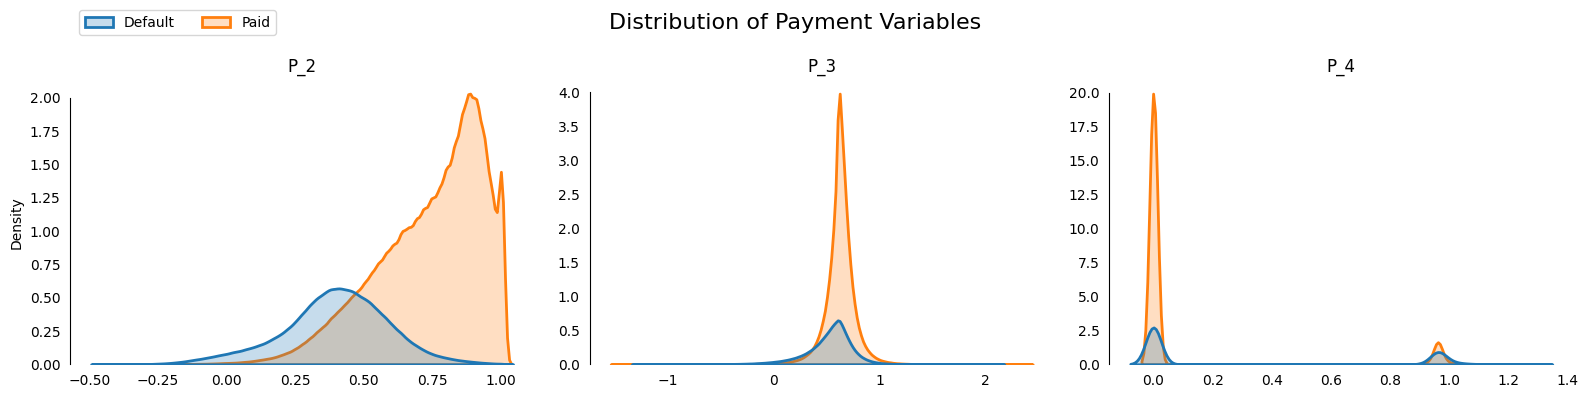

In [151]:
cols=[col for col in train.columns if (col.startswith(('P','t'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Distribution of Payment Variables',fontsize=16)
for i, col in enumerate(plot_df.columns[:-1]):
    sns.kdeplot(x=col, hue='target', hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[i])
    ax[i].tick_params(left=False,bottom=False)
    ax[i].set(title='{}'.format(col), xlabel='', ylabel=('Density' if i==0 else ''))
handles, _ = ax[0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 1))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

C:\Users\brito\AppData\Local\Temp\ipykernel_4548\2828756232.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


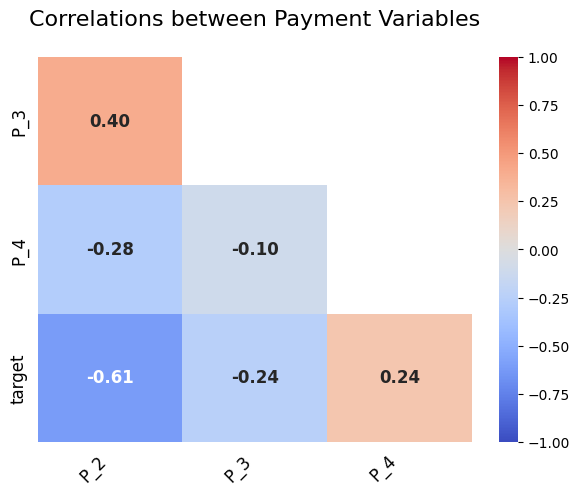

In [152]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(7,5)) 
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'})
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Payment Variables\n', fontsize=16)
fig.show()

* B_* = Balance variables

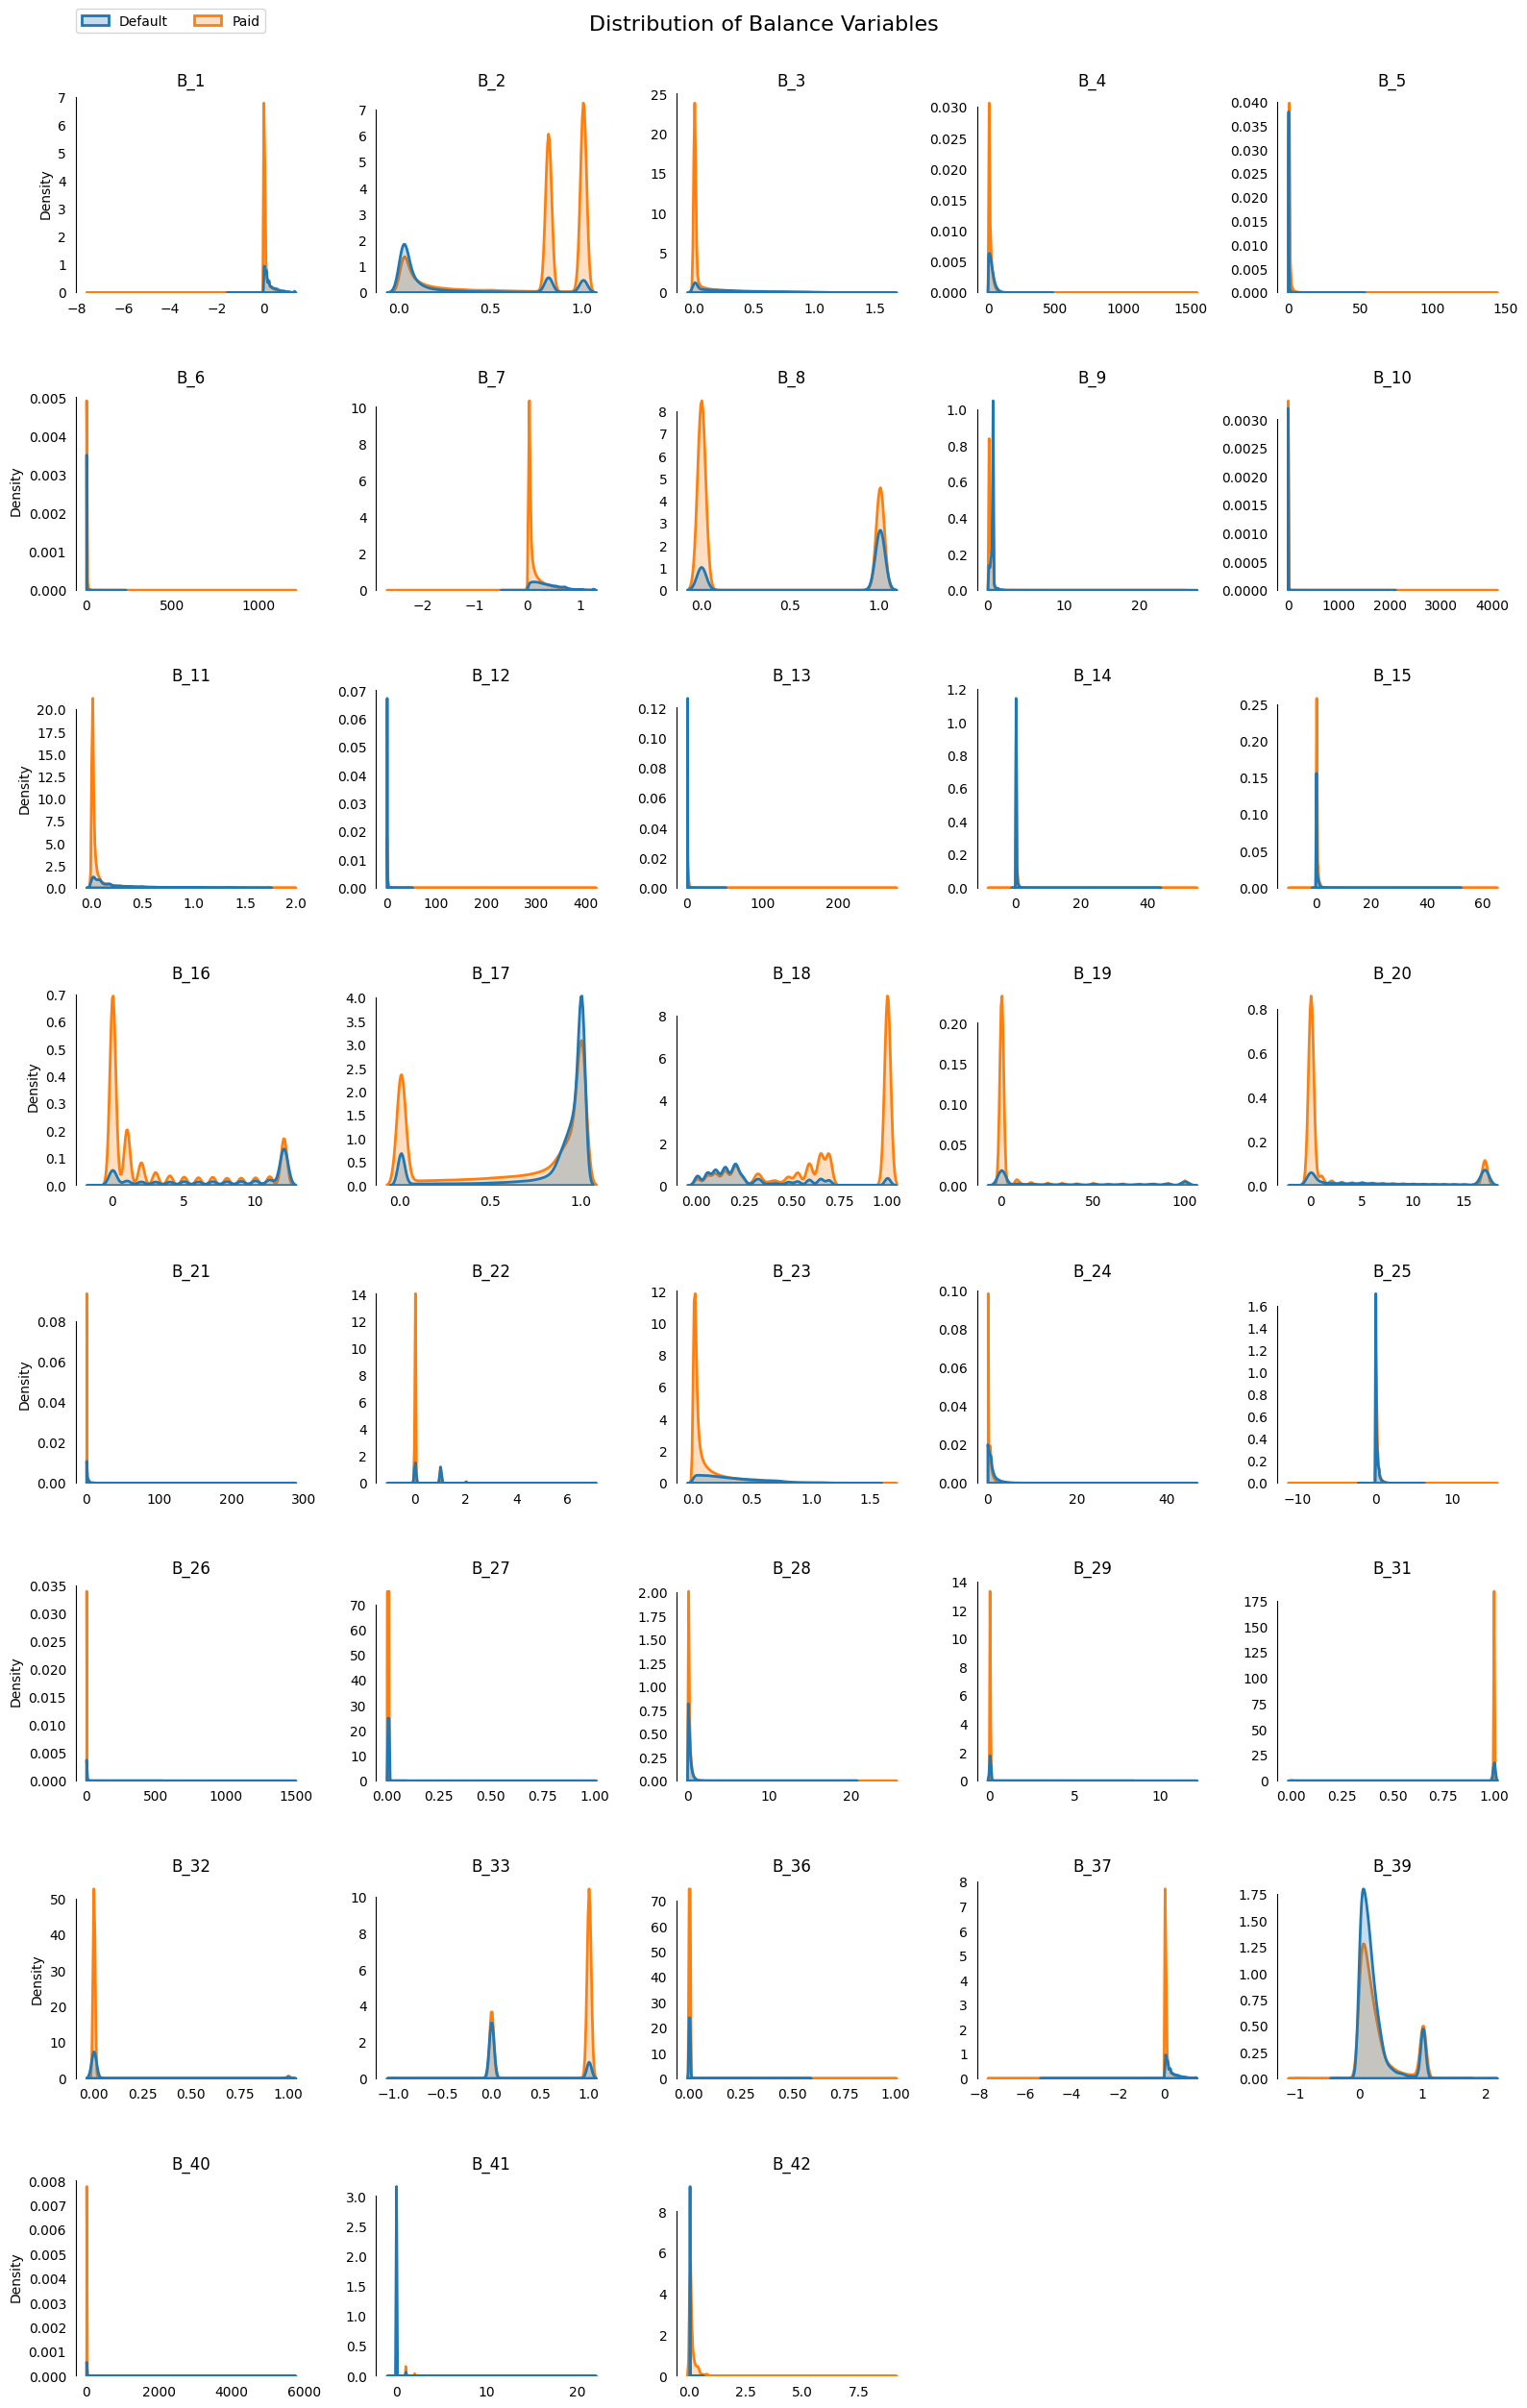

In [154]:
cols=[col for col in train.columns if (col.startswith(('B','t'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(8,5, figsize=(16,32))
fig.suptitle('Distribution of Balance Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*8
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(3,5):
    ax[7,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.984))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])


C:\Users\brito\AppData\Local\Temp\ipykernel_4548\406786768.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


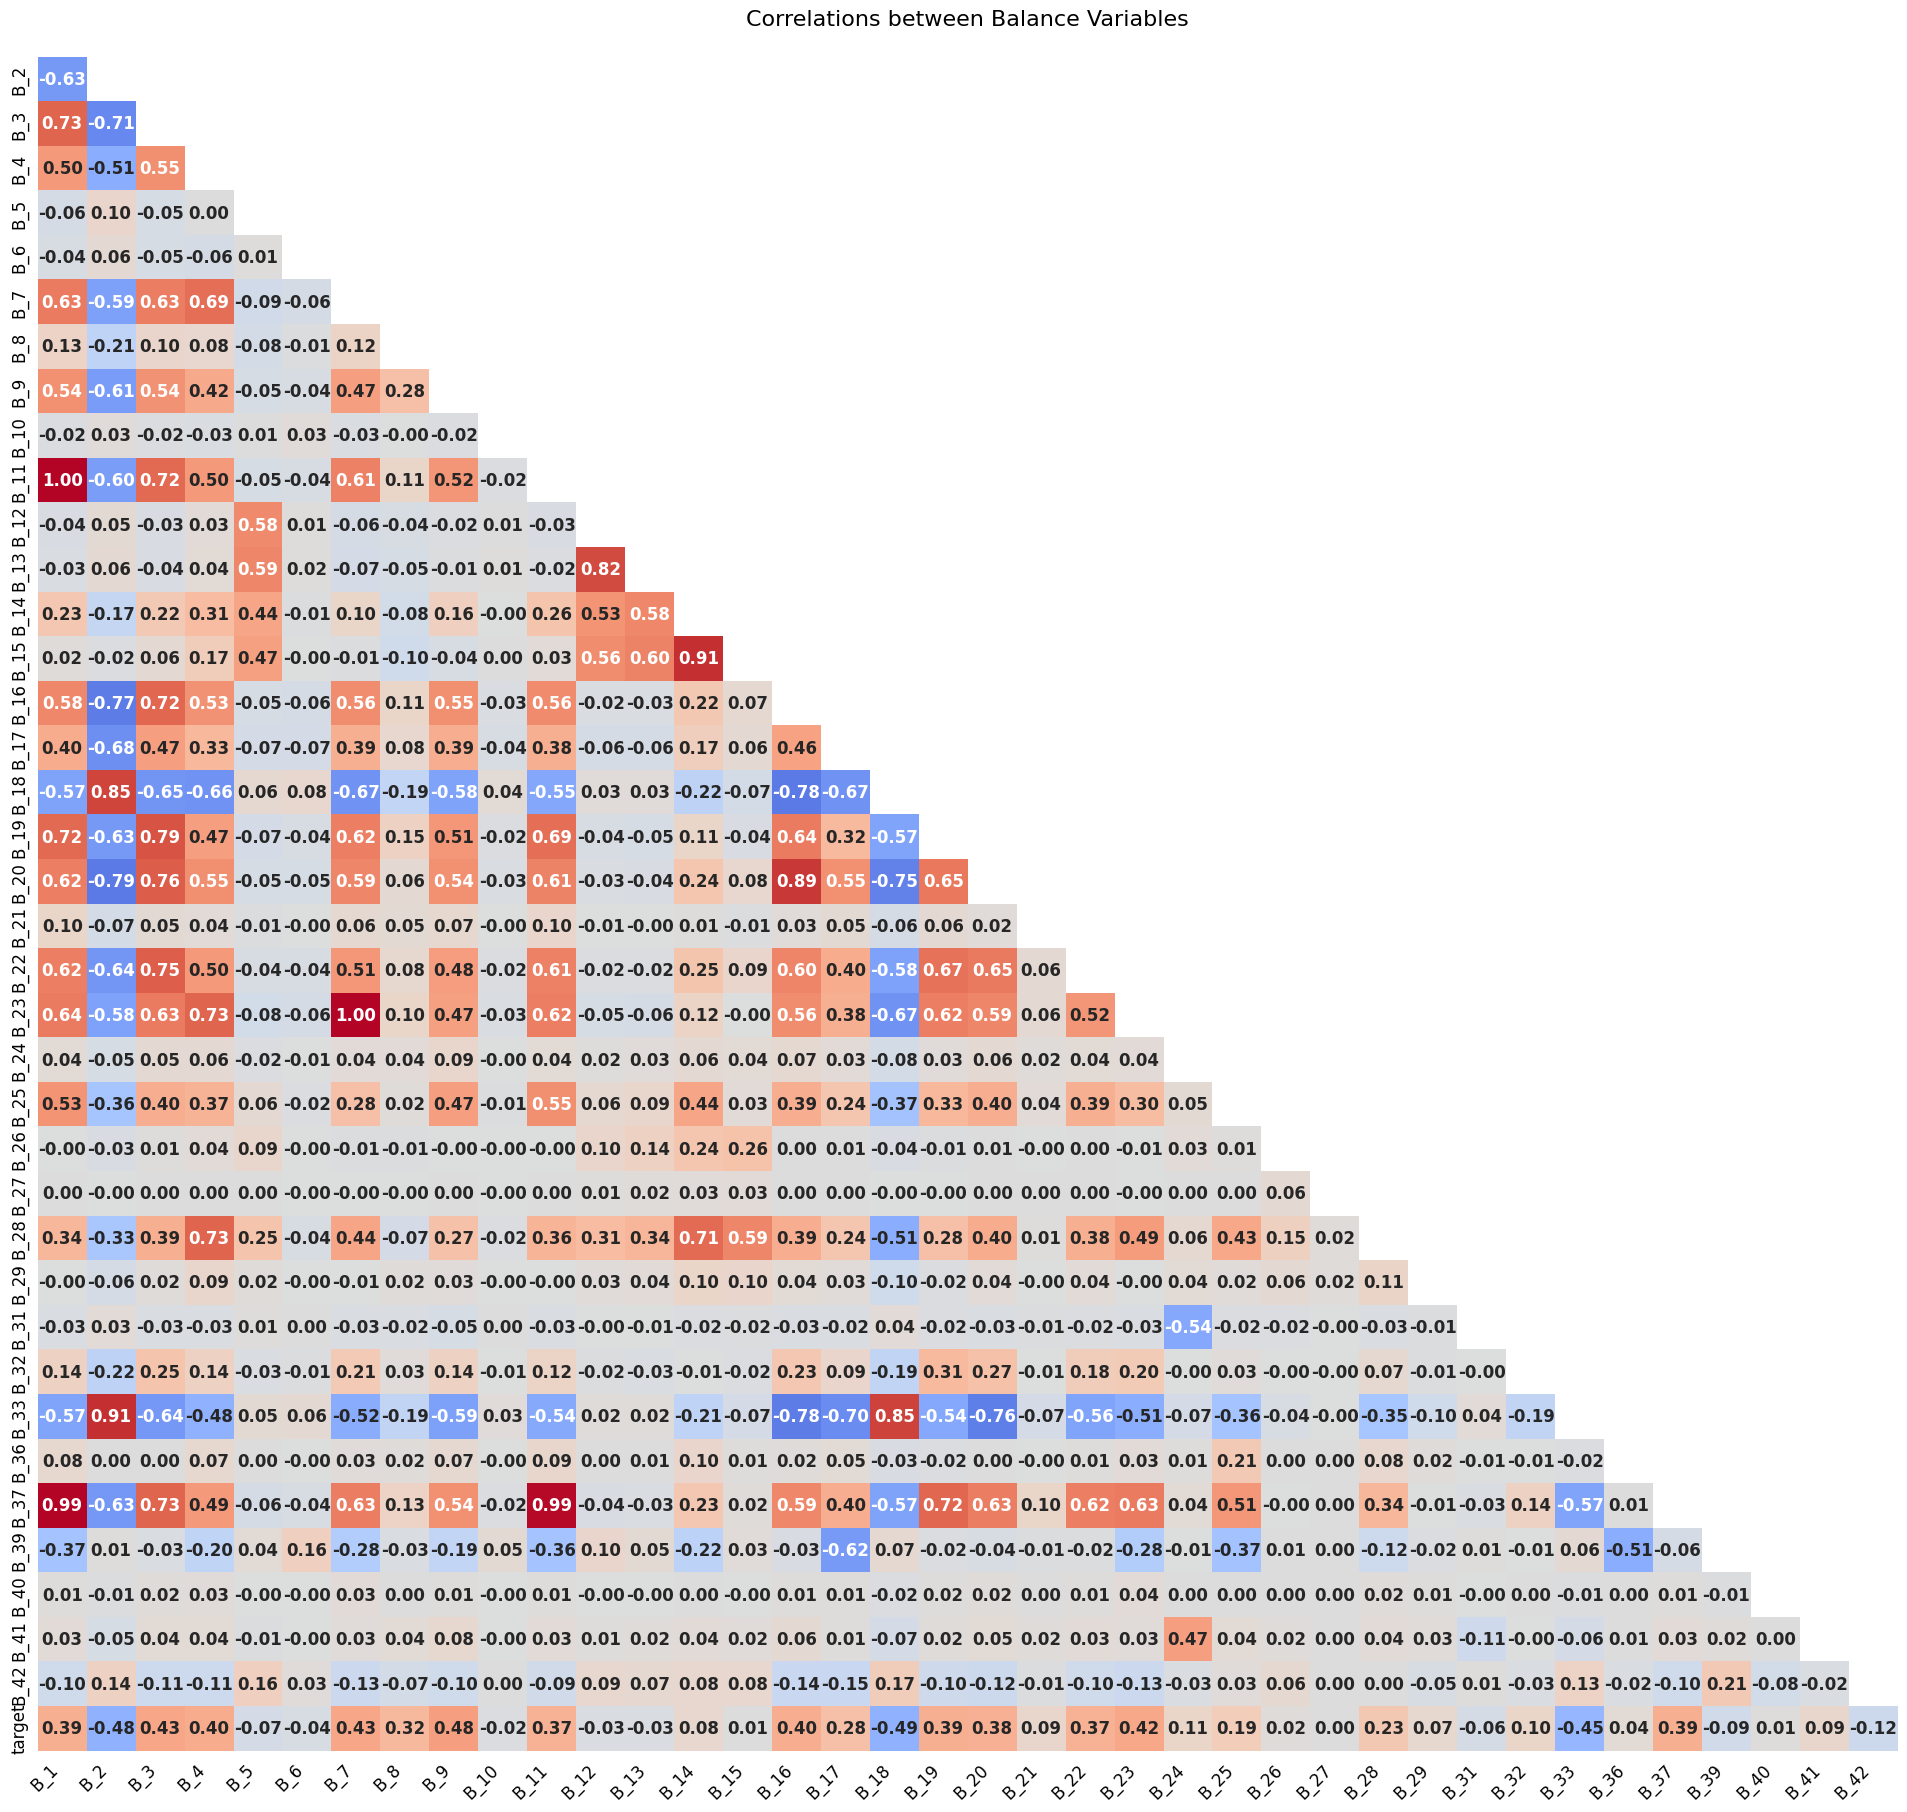

In [155]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(24,22))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Balance Variables\n', fontsize=16)
fig.show()


* R_* = Risk variables

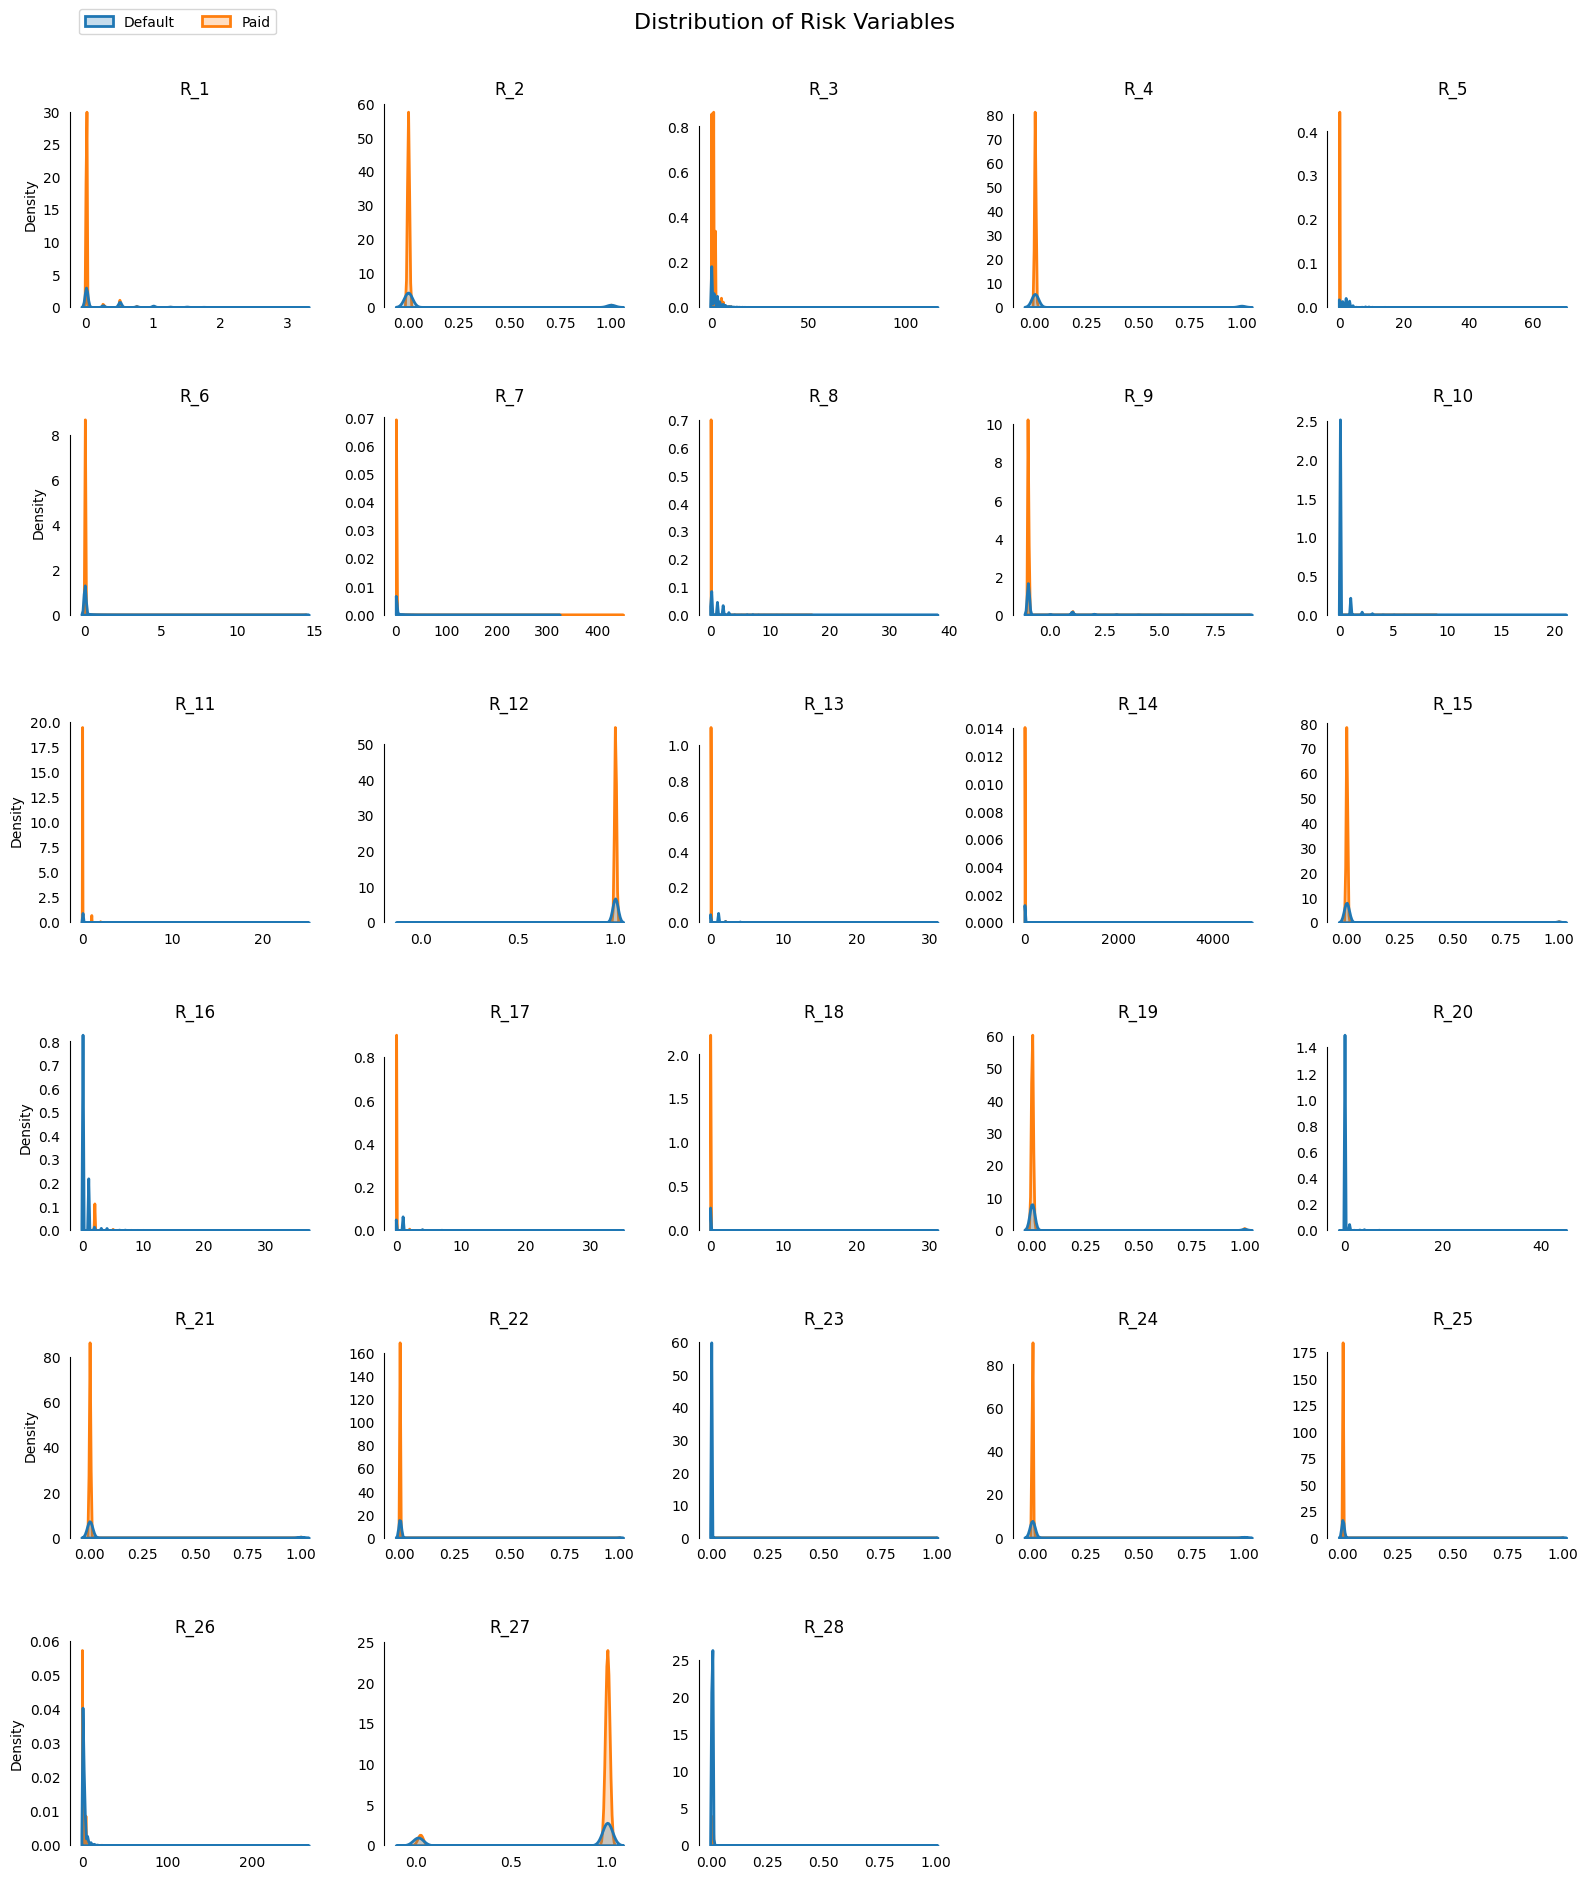

In [156]:
cols=[col for col in train.columns if (col.startswith(('R','t'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(6,5, figsize=(16,24))
fig.suptitle('Distribution of Risk Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*6
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(3,5):
    ax[5,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.984))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

C:\Users\brito\AppData\Local\Temp\ipykernel_4548\402279985.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


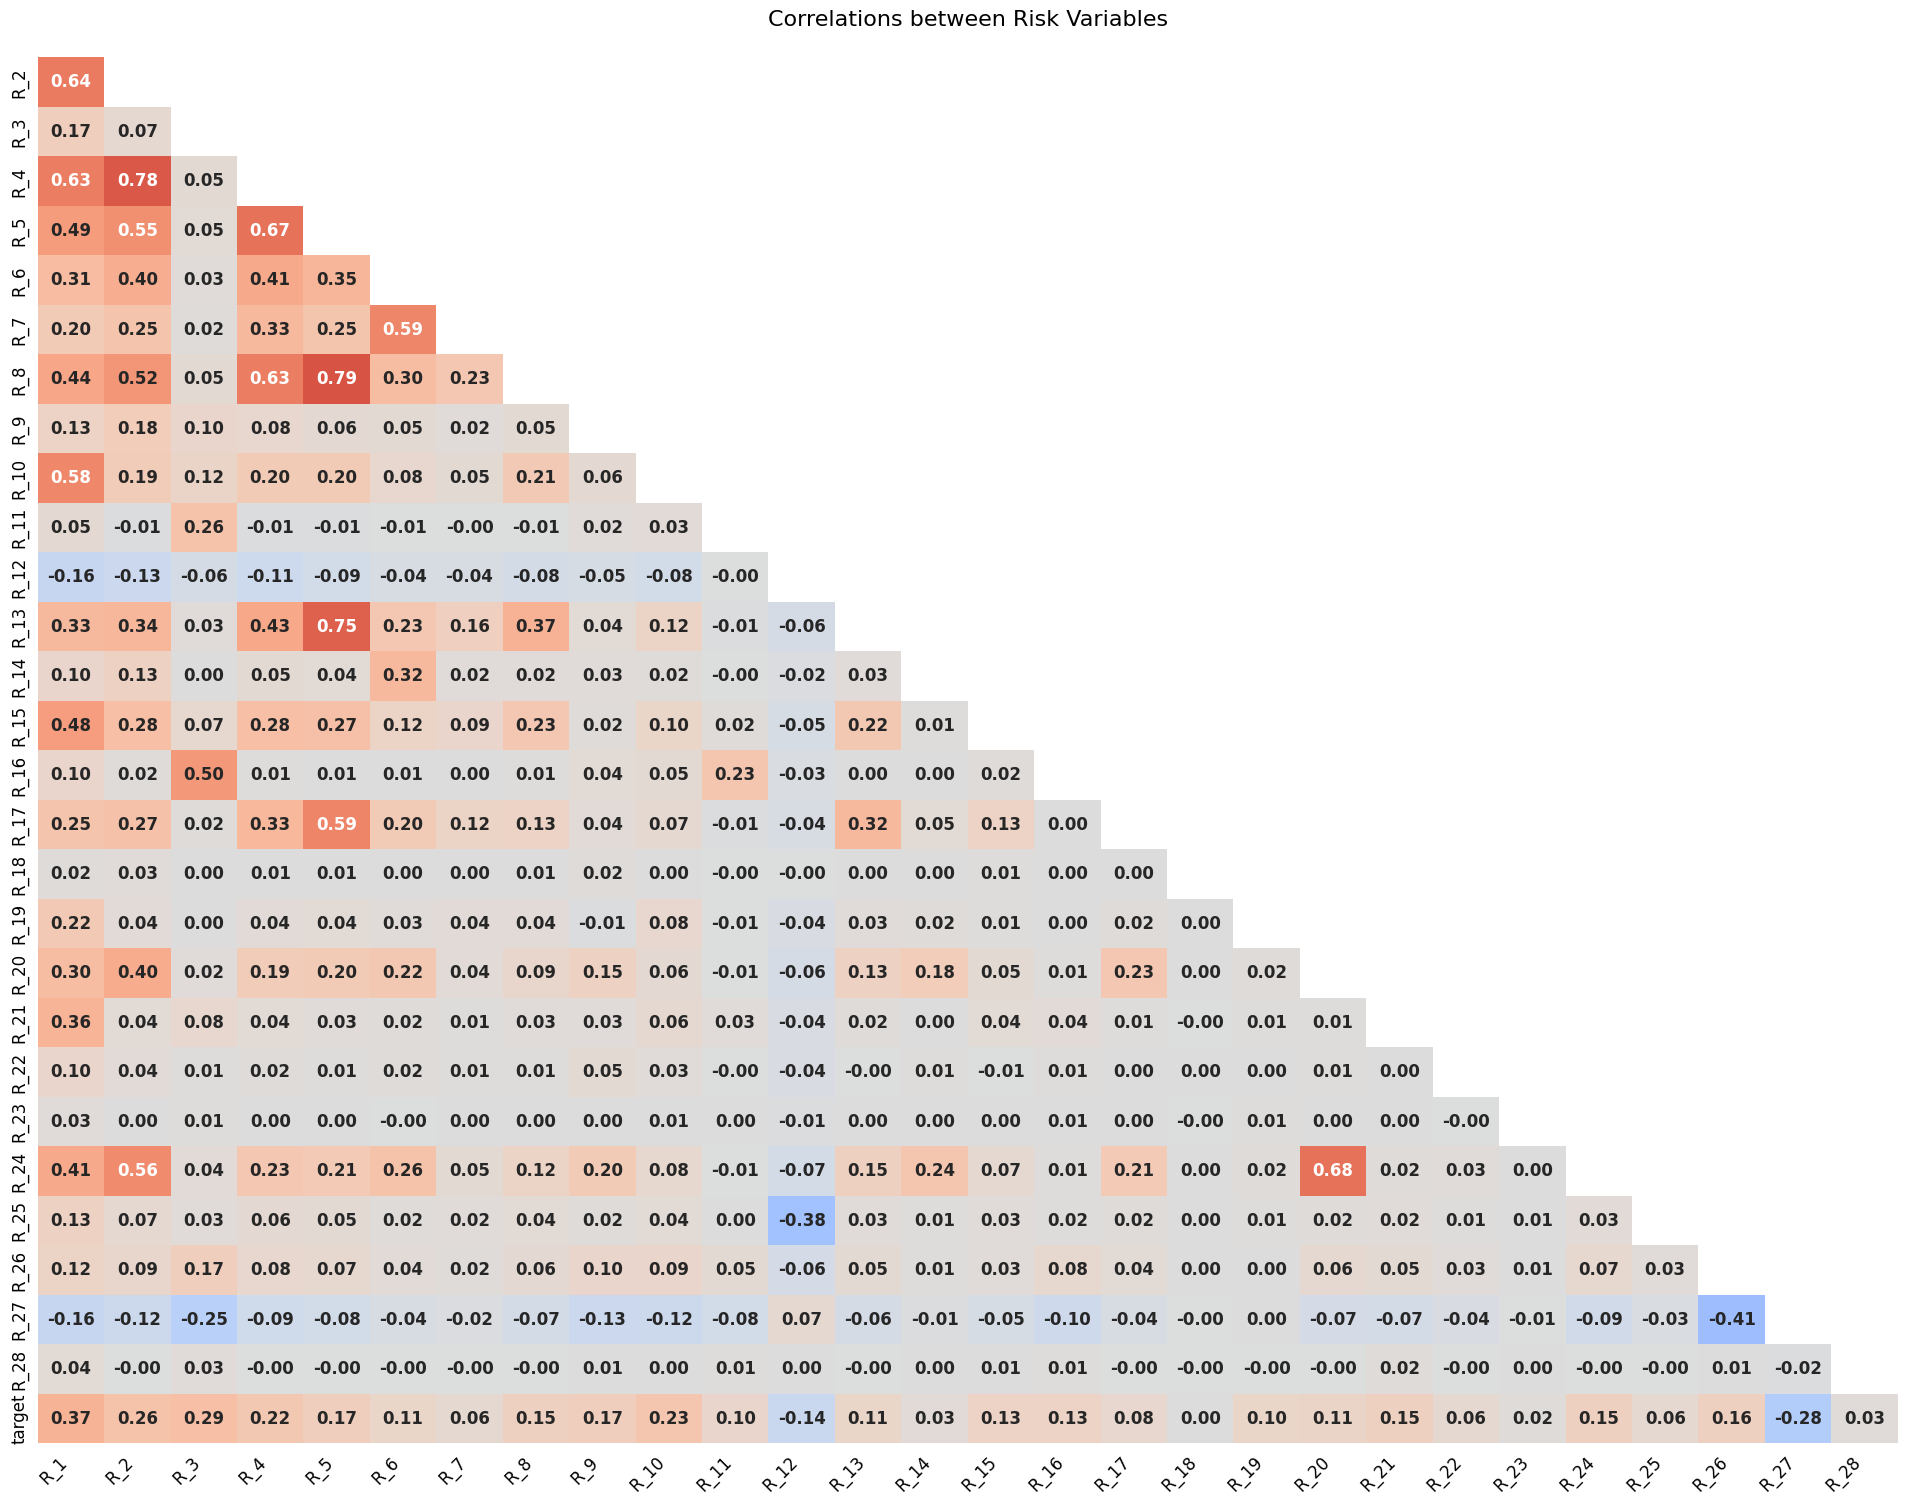

In [157]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(24,18))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':12,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Risk Variables\n', fontsize=16)
fig.show()


### EDA of Categorial Features